# Spectroscopic Production Database Tutorial

## Abstract

This tutorial will cover the basics of using the spectroscopic production database, which is loaded from the outputs of the DESI pipeline.  Currently, this is based on software "release" `main`, and uses a [PostgreSQL](https://www.postgresql.org/) database. We use [SQLAlchemy](http://www.sqlalchemy.org/) to abstract away the details of the database.

## Requirements

This tutorial uses data from the `fuji` production (`/global/cfs/cdirs/desi/public/edr/spectro/redux/fuji`), and the **DESI main** kernel.

## Initial Setup

This just imports everything we need and sets up paths and environment variables so we can find things.

In [1]:
#
# Imports
#
import os
from argparse import Namespace
from types import MethodType
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import fontManager, FontProperties
from sqlalchemy import __version__ as sqlalchemy_version
from sqlalchemy import inspect
from sqlalchemy.sql import func
import astropy.units as u
from astropy.constants import c as lightspeed
from astropy.table import Table, MaskedColumn
#
# DESI software
#
from desiutil.log import get_logger, DEBUG
from desitarget.targetmask import (desi_mask, mws_mask, bgs_mask)
# from desisim.spec_qa import redshifts as dsq_z
from desisurvey import __version__ as desisurvey_version
from desisurvey.ephem import get_ephem, get_object_interpolator
from desisurvey.utils import get_observer
from desispec import __version__ as desispec_version
import desispec.database.redshift as db
#
# Paths to files, etc.
#
specprod = os.environ['SPECPROD'] = 'fuji'
basedir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], specprod)
# surveydir = os.environ['DESISURVEY_OUTPUT'] = os.path.join(basedir, 'survey')
# targetdir = os.path.join(basedir, 'targets')
# fibassigndir = os.path.join(basedir, 'fiberassign')
# os.environ['DESI_SPECTRO_REDUX'] = os.path.join(basedir, 'spectro', 'redux')
# os.environ['DESI_SPECTRO_SIM'] = os.path.join(basedir, 'spectro', 'sim')
# os.environ['PIXPROD'] = 'mini'
# os.environ['SPECPROD'] = 'mini'
# reduxdir = os.path.join(os.environ['DESI_SPECTRO_REDUX'], os.environ['SPECPROD'])
# simdatadir = os.path.join(os.environ['DESI_SPECTRO_SIM'], os.environ['PIXPROD'])
# os.environ['DESI_SPECTRO_DATA'] = simdatadir
#
# Initialize ephemerides, to find Moon, etc.
#
os.environ['DESISURVEY_OUTPUT'] = os.environ['SCRATCH']
ephem = get_ephem()
#
# get_ephem() will run freeze_iers(), so we import these after that.
#
from astropy.time import Time
from astropy.coordinates import ICRS
#
# Working directory.
#
workingdir = os.getcwd()
print(f'sqlalchemy=={sqlalchemy_version}')
print(f'desispec=={desispec_version}')
print(f'desisurvey=={desisurvey_version}')

INFO:iers.py:82:freeze_iers: Freezing IERS table used by astropy time, coordinates.
INFO:ephem.py:80:get_ephem: Restored ephemerides for (2019-01-01,2027-12-31) from /pscratch/sd/b/bweaver/ephem_2019-01-01_2027-12-31.fits.
sqlalchemy==1.4.29
desispec==0.55.0.dev7463
desisurvey==0.19.0.dev1131


This function will compute various Moon paramters needed below.

In [2]:
def moon(self, mjd, ra, dec):
    """Compute relative location of the Moon.
    
    Parameters
    ----------
    mjd : float
        Time of observation
    ra : float
        Right Ascension
    dec : float
        Declination
    
    Returns
    -------
    tuple
        Moon separation, Moon altitude, Moon illumination fraction
    """
    observation_time = Time(mjd, format='mjd')
    position = ICRS(ra=ra*u.deg, dec=dec*u.deg)
    zenith = get_observer(observation_time, alt=90 * u.deg, az=0 * u.deg).transform_to(ICRS)
    alt = 90 * u.deg - position.separation(zenith)
    moon_dec, moon_ra = get_object_interpolator(self.get_night(observation_time), 'moon', altaz=False)(observation_time.mjd)
    moon_position = ICRS(ra=moon_ra*u.deg, dec=moon_dec*u.deg)
    moon_sep = position.separation(moon_position).to(u.deg).value
    moon_alt = (90 * u.deg - moon_position.separation(zenith)).to(u.deg).value
    moon_frac = ephem.get_moon_illuminated_fraction(observation_time.mjd).tolist()
    return (moon_sep, moon_alt, moon_frac)

ephem.moon = MethodType(moon, ephem)

## Contents of the Database

All tables are grouped into a database *schema* and that schema is named for the production run, (*e.g.* `fuji`).  When writing "raw" SQL, table names need to be schema-qualified, for example, `fuji.target`.  However, the SQLAlchemy abstraction layer is designed to take care of this for you.

Important notes:

* This database does not contain any sky spectra. Both deliberately-targeted (`targetid & 2**59 != 0`) and negative targetid (`targetid < 0`) sky spectra are excluded.
* Only cumulative tile-based spectra are included at the present time.

The tables are:

* `photometry`. This contains the pure photometric data. Usually this is derived from the LS DR9 Tractor data, but not every *targeted* object has Tractor photometry.
  - Loaded from `tractorphot` files: `/global/cfs/cdirs/desi/public/edr/vac/lsdr9-photometry/v1.0/potential-targets/tractorphot/tractorphot-potential-*-${SPECPROD}.fits`.
  - SQLAlchemy object: `db.Photometry`.
  - Primary key: `targetid`.
* `target`. This contains the targeting bits and other data generated by `desitarget`.
  - Loaded from `targetphot` file: `/global/cfs/cdirs/desi/public/edr/vac/lsdr9-photometry/v1.0/potential-targets/targetphot-potential-${SPECPROD}.fits`.
  - SQLAlchemy object: `db.Target`.
  - Primary key: (`targetid`, `survey`, `tileid`)
* `tile`. This contains information about observations grouped by tile.
  - Loaded from top-level `tiles-${SPECPROD}.fits`.
  - SQLAlchemy object: `db.Tile`.
  - Primary key: `tileid`.
* `exposure`. This contains information about individual exposures.
  - Loaded from top-level `exposures-${SPECPROD}.fits`, `EXPOSURES` HDU.
  - SQLAlchemy object: `db.Exposure`.
  - Primary key: `expid`.
* `frame`. This contains information about individual exposures, but broken down by camera.  There will usually, but not always, be 30 frames per exposure.
  - Loaded from top-level `exposures-${SPECPROD.fits`, `FRAMES` HDU.
  - SQLAlchemy object: `db.Frame`.
  - Primary key: `frameid`, composed from `expid` and a mapping of `camera` to an arbitrary integer.
* `fiberassign`. This contains information about fiber positions.
  - Loaded from fiberassign files in the tiles product.  All fiberassign files corresponding to tiles in the `tile` table are loaded.
  - SQLAlchemy object: `db.Fiberassign`.
  - Primary key: (`tileid`, `targetid`, `location`)
* `potential`. This contains a list of `targetid`s that *could* have been targeted on a given tile.
  - Loaded from the `POTENTIAL_ASSIGNMENTS` HDU in the same fiberassign files mentioned above.
  - SQLAlchemy object: `db.Potential`.
  - Primary key: (`tileid`, `targetid`, `location`)
* `zpix`. This contains the pipeline redshifts grouped by HEALPixel.
  - Loaded from the `zall-pix-${SPECPROD}.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Zpix`.
  - Primary key: (`targetid`, `survey`, `program`)
* `ztile`. This contains the pipeline redshifts grouped by tile in a variety of ways.
  - Loaded from the `zall-tilecumulative-${SPECPROD}.fits` file in the `zcatalog/` directory.
  - SQLAlchemy object: `db.Ztile`
  - Primary key: (`targetid`, `spgrp`, `spgrpval`, `tileid`)

## Initial Database Connection

This connection uses a `~/.pgpass` file to set up connection credentials.  [Be sure you have set that up](https://desi.lbl.gov/trac/wiki/DESIProductionDatabase#Setuppgpass).

In [3]:
#
# For much more output, use DEBUG/verbose mode.
#
# db.log = get_logger(DEBUG)
# postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi', verbose=True)
db.log = get_logger()
postgresql = db.setup_db(schema=specprod, hostname='nerscdb03.nersc.gov', username='desi')

## Learning About the Tables

The tables in the database are listed above.  To inspect an individual table, you can use the `__table__` attribute.

In [4]:
#
# Print the table columns and their types.
#
[(c.name, c.type) for c in db.Zpix.__table__.columns]

[('id', Numeric(precision=39)),
 ('targetid', BigInteger()),
 ('survey', String(length=7)),
 ('program', String(length=6)),
 ('spgrp', String(length=10)),
 ('spgrpval', Integer()),
 ('healpix', Integer()),
 ('z', DOUBLE_PRECISION()),
 ('zerr', DOUBLE_PRECISION()),
 ('zwarn', BigInteger()),
 ('chi2', DOUBLE_PRECISION()),
 ('coeff_0', DOUBLE_PRECISION()),
 ('coeff_1', DOUBLE_PRECISION()),
 ('coeff_2', DOUBLE_PRECISION()),
 ('coeff_3', DOUBLE_PRECISION()),
 ('coeff_4', DOUBLE_PRECISION()),
 ('coeff_5', DOUBLE_PRECISION()),
 ('coeff_6', DOUBLE_PRECISION()),
 ('coeff_7', DOUBLE_PRECISION()),
 ('coeff_8', DOUBLE_PRECISION()),
 ('coeff_9', DOUBLE_PRECISION()),
 ('npixels', BigInteger()),
 ('spectype', String(length=6)),
 ('subtype', String(length=20)),
 ('ncoeff', BigInteger()),
 ('deltachi2', DOUBLE_PRECISION()),
 ('coadd_fiberstatus', Integer()),
 ('coadd_numexp', SmallInteger()),
 ('coadd_exptime', REAL()),
 ('coadd_numnight', SmallInteger()),
 ('coadd_numtile', SmallInteger()),
 ('mean_de

We can also `inspect()` the database.  For details see [here](http://docs.sqlalchemy.org/en/latest/core/inspection.html?highlight=inspect#module-sqlalchemy.inspection).

In [5]:
inspector = inspect(db.engine)
for table_name in inspector.get_table_names(schema=specprod):
    print(table_name)
    for column in inspector.get_columns(table_name, schema=specprod):
        print("Column: {name} {type}".format(**column))

potential
Column: id NUMERIC(39, 0)
Column: tileid INTEGER
Column: targetid BIGINT
Column: fiber INTEGER
Column: location INTEGER
zpix
Column: id NUMERIC(39, 0)
Column: targetid BIGINT
Column: survey VARCHAR(7)
Column: program VARCHAR(6)
Column: spgrp VARCHAR(10)
Column: spgrpval INTEGER
Column: healpix INTEGER
Column: z DOUBLE_PRECISION
Column: zerr DOUBLE_PRECISION
Column: zwarn BIGINT
Column: chi2 DOUBLE_PRECISION
Column: coeff_0 DOUBLE_PRECISION
Column: coeff_1 DOUBLE_PRECISION
Column: coeff_2 DOUBLE_PRECISION
Column: coeff_3 DOUBLE_PRECISION
Column: coeff_4 DOUBLE_PRECISION
Column: coeff_5 DOUBLE_PRECISION
Column: coeff_6 DOUBLE_PRECISION
Column: coeff_7 DOUBLE_PRECISION
Column: coeff_8 DOUBLE_PRECISION
Column: coeff_9 DOUBLE_PRECISION
Column: npixels BIGINT
Column: spectype VARCHAR(6)
Column: subtype VARCHAR(20)
Column: ncoeff BIGINT
Column: deltachi2 DOUBLE_PRECISION
Column: coadd_fiberstatus INTEGER
Column: coadd_numexp SMALLINT
Column: coadd_exptime REAL
Column: coadd_numnight

### Exercises

* What is the type of the `night` column of the `exposures` table?
* What is the primary key of the `ztile` table?

## Simple Queries

Queries are set up with the `.query()` method on Session objects.  In this case, there's a prepared Session object called `db.dbSession`.  `.filter()` corresponds to a `WHERE` clause in SQL.

### Exposures, Nights, Tiles

Here are some simple queries that demonstrate simple connections between nights, exposures and tiles.

In [6]:
# Number of tiles.
q = db.dbSession.query(db.Tile).count()
q

732

In [7]:
# Tiles observed on a particluar night.
q = db.dbSession.query(db.Exposure.tileid, db.Exposure.survey, db.Exposure.program).filter(db.Exposure.night == 20210115).all()
q

[(80655, 'sv1', 'bright'),
 (80680, 'sv1', 'dark'),
 (80680, 'sv1', 'dark'),
 (80660, 'sv1', 'bright'),
 (80660, 'sv1', 'bright'),
 (80715, 'sv1', 'other'),
 (80715, 'sv1', 'other'),
 (80715, 'sv1', 'other'),
 (80674, 'sv1', 'dark'),
 (80674, 'sv1', 'dark'),
 (80674, 'sv1', 'dark'),
 (80683, 'sv1', 'dark'),
 (80683, 'sv1', 'dark'),
 (80678, 'sv1', 'dark'),
 (80678, 'sv1', 'dark'),
 (80688, 'sv1', 'dark'),
 (80688, 'sv1', 'dark'),
 (80685, 'sv1', 'dark'),
 (80685, 'sv1', 'dark'),
 (80662, 'sv1', 'bright'),
 (80662, 'sv1', 'bright'),
 (80663, 'sv1', 'bright'),
 (80663, 'sv1', 'bright'),
 (80690, 'sv1', 'dark'),
 (80690, 'sv1', 'dark'),
 (80653, 'sv1', 'bright'),
 (80653, 'sv1', 'bright'),
 (80700, 'sv1', 'dark'),
 (80700, 'sv1', 'dark'),
 (80699, 'sv1', 'dark'),
 (80699, 'sv1', 'dark'),
 (80665, 'sv1', 'bright'),
 (80665, 'sv1', 'bright'),
 (80707, 'sv1', 'dark'),
 (80707, 'sv1', 'dark')]

In [8]:
# On what nights were tile 100 observed?
q = db.dbSession.query(db.Exposure.night, db.Exposure.expid).filter(db.Exposure.tileid == 100).all()
q

[(20210504, 87236), (20210505, 87361)]

### Select ELG Targets

Note the special way we obtain the bitwise and operator.

In [9]:
q = db.dbSession.query(db.Target).filter(db.Target.desi_target.op('&')(desi_mask.ELG) != 0).all()
q[:10]

[Target(targetid=39628273327539288, tileid=81100, survey='special'),
 Target(targetid=39628273327539304, tileid=81100, survey='special'),
 Target(targetid=39628273327539661, tileid=81100, survey='special'),
 Target(targetid=39628273327540514, tileid=81100, survey='special'),
 Target(targetid=39628273327539105, tileid=81100, survey='special'),
 Target(targetid=39628273327540710, tileid=81100, survey='special'),
 Target(targetid=39628273327541426, tileid=81100, survey='special'),
 Target(targetid=39628273327541480, tileid=81100, survey='special'),
 Target(targetid=39628273327541945, tileid=81100, survey='special'),
 Target(targetid=39628273327542474, tileid=81100, survey='special')]

In [10]:
[(row.targetid, row.desi_target, row.survey, row.program, row.tileid) for row in q[:10]]

[(39628273327539288, 655458, 'special', 'dark', 81100),
 (39628273327539304, 4611686018428305446, 'special', 'dark', 81100),
 (39628273327539661, 655458, 'special', 'dark', 81100),
 (39628273327540514, 655394, 'special', 'dark', 81100),
 (39628273327539105, 4611686018428305446, 'special', 'dark', 81100),
 (39628273327540710, 655458, 'special', 'dark', 81100),
 (39628273327541426, 655458, 'special', 'dark', 81100),
 (39628273327541480, 655394, 'special', 'dark', 81100),
 (39628273327541945, 917542, 'special', 'dark', 81100),
 (39628273327542474, 917606, 'special', 'dark', 81100)]

#### Exercise

* How many objects in the `zpix` table have `spectype` 'GALAXY'?

### Redshift and Classification

Simple query filtering on string values. Note that the slice notation `[:20]` is equivalent to `LIMIT 20` in SQL.

In [11]:
q = db.dbSession.query(db.Zpix.spectype, db.Zpix.subtype, db.Zpix.z).filter(db.Zpix.spectype == 'STAR').filter(db.Zpix.subtype != '')[:20]
q

[('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -3.75605406508605e-05),
 ('STAR', 'G', -6.60747391019077e-05),
 ('STAR', 'M', 9.8335838129404e-05),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', -0.000187595450424383),
 ('STAR', 'G', -0.000245578117524253),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'K', 0.000100795469925271),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'CV', -0.00199569129234795),
 ('STAR', 'M', -8.97785163529219e-05),
 ('STAR', 'M', -4.33558174813776e-05),
 ('STAR', 'CV', -0.00199569129234795)]

## Joining Tables

### A Simple Join

Let's look at the nights and exposures on which a particular `TARGETID` was observed.

In [12]:
q = db.dbSession.query(db.Fiberassign.tileid, db.Exposure.expid, db.Exposure.night).filter(db.Fiberassign.tileid == db.Exposure.tileid).filter(db.Fiberassign.targetid == 933811403620352).all()
q

[(278, 85086, 20210416),
 (279, 85209, 20210417),
 (279, 85207, 20210417),
 (279, 85206, 20210417),
 (279, 85208, 20210417),
 (280, 86981, 20210502),
 (280, 86980, 20210502)]

### Another Simple Join

In this case, we'll look at photometric flux and measured redshift. We'll `LIMIT` the query with slice notation.

In [18]:
q = db.dbSession.query(db.Photometry, db.Zpix).filter(db.Photometry.targetid == db.Zpix.targetid).order_by(db.Zpix.z, db.Photometry.flux_g)[:50]

In [19]:
[(row.Photometry.flux_g, row.Photometry.flux_r, row.Photometry.flux_z, row.Zpix.z) for row in q]

[(0.0, 0.0, 0.0, -0.005),
 (0.0, 0.0, 0.0, -0.005),
 (0.0, 0.0, 0.0, -0.005),
 (0.288389, 0.399304, 0.658613, -0.005),
 (0.371317, 0.500192, 0.926787, -0.005),
 (0.376231, 0.462276, 0.735718, -0.005),
 (0.402784, 0.492405, 0.729579, -0.005),
 (0.423864, 0.508099, 0.905529, -0.005),
 (0.645119, 0.751905, 1.32465, -0.005),
 (0.763588, 0.981288, 1.35165, -0.005),
 (0.801658, 1.18934, 1.3972, -0.005),
 (1.03619, 1.16814, 0.885411, -0.005),
 (1.97763, 7.93039, 17.0531, -0.005),
 (3.36023, 4.87858, 5.37419, -0.005),
 (30.6108, 42.9943, 46.7004, -0.005),
 (0.322118, 0.260959, 0.380534, -0.00498711921143957),
 (0.301417, 0.322585, 0.620725, -0.00498464799337274),
 (0.282215, 0.150698, 0.302225, -0.00498389817403406),
 (0.0, 0.0, 0.0, -0.00497712431274103),
 (0.289591, 0.421891, 0.285822, -0.00497480828100477),
 (0.758101, 1.3058, 2.06423, -0.00496785500847381),
 (0.321924, 0.229319, 0.286182, -0.00496686452525558),
 (6.79679, 12.0986, 14.6919, -0.00496137489562983),
 (0.943244, 1.34712, 1.6834

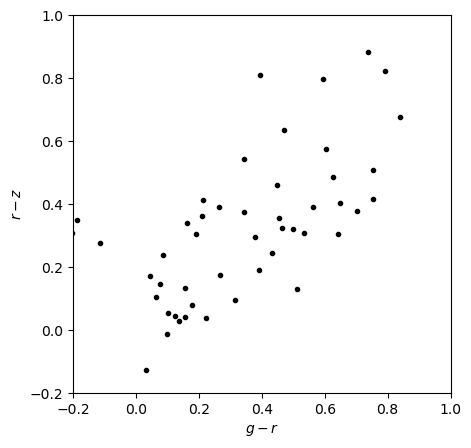

In [15]:
flux_g = np.array([row.Photometry.flux_g for row in q])
flux_r = np.array([row.Photometry.flux_r for row in q])
flux_z = np.array([row.Photometry.flux_z for row in q])
g_minus_r = np.log10(flux_r/flux_g)
r_minus_z = np.log10(flux_z/flux_r)
redshift = np.array([row.Zpix.z for row in q])
fig, axes = plt.subplots(1, 1, figsize=(5, 5), dpi=100)
p = axes.plot(g_minus_r, r_minus_z, 'k.')
foo = axes.set_xlim([-0.2, 1.0])
foo = axes.set_ylim([-0.2, 1.0])
foo = axes.set_aspect('equal')
foo = axes.set_xlabel('$g - r$')
foo = axes.set_ylabel('$r - z$')

#### Exercise

* Create a color-color plot for objects targeted as QSOs, and spectroscopically confirmed as such.

### A More Complicated Join

Let's look at objects that appear on more than one tile. For each of those tiles, how many exposures where there?

In this example, we're using `sqlalchemy.sql.func` to get the equivalent of `COUNT(*)` and a subquery that itself is a multi-table join.

In [20]:
# db.dbSession.rollback()
q1 = db.dbSession.query(db.Fiberassign.targetid, func.count('*').label('n_assign')).group_by(db.Fiberassign.targetid).subquery()
q2 = db.dbSession.query(db.Tile.nexp, db.Fiberassign.tileid, q1.c.targetid, q1.c.n_assign).filter(q1.c.n_assign>2).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Tile.tileid == db.Fiberassign.tileid)[:100]

In [21]:
q2

[(1, 278, 933811403620352, 3),
 (4, 279, 933811403620352, 3),
 (2, 280, 933811403620352, 3),
 (1, 113, 934457234161664, 3),
 (2, 114, 934457234161664, 3),
 (1, 117, 934457234161664, 3),
 (2, 385, 934560644726784, 3),
 (1, 388, 934560644726784, 3),
 (1, 436, 934560644726784, 3),
 (1, 486, 1000347531214848, 3),
 (1, 487, 1000347531214848, 3),
 (1, 488, 1000347531214848, 3),
 (1, 86, 1009771901616128, 4),
 (1, 87, 1009771901616128, 4),
 (2, 88, 1009771901616128, 4),
 (2, 89, 1009771901616128, 4),
 (2, 280, 1017422609907712, 3),
 (1, 281, 1017422609907712, 3),
 (1, 472, 1017422609907712, 3),
 (1, 331, 1018270354243585, 3),
 (1, 334, 1018270354243585, 3),
 (1, 478, 1018270354243585, 3),
 (2, 578, 1018296853856257, 3),
 (1, 580, 1018296853856257, 3),
 (1, 581, 1018296853856257, 3),
 (1, 85, 1018553679478786, 4),
 (2, 88, 1018553679478786, 4),
 (2, 89, 1018553679478786, 4),
 (1, 92, 1018553679478786, 4),
 (2, 89, 1018567994638338, 3),
 (1, 90, 1018567994638338, 3),
 (1, 92, 1018567994638338, 

Now let's see what the redshift table thinks are the number of exposures for these objects.

In [22]:
q3 = db.dbSession.query(db.Zpix).filter(db.Zpix.targetid.in_([row[2] for row in q2])).all()

In [23]:
[(row.coadd_numexp, row.zcat_nspec) for row in q3]

[(3, 1),
 (3, 1),
 (4, 1),
 (3, 1),
 (4, 1),
 (4, 1),
 (3, 1),
 (4, 1),
 (6, 1),
 (4, 1),
 (4, 1),
 (5, 1),
 (3, 1),
 (3, 1),
 (4, 1),
 (4, 1),
 (2, 1),
 (4, 1),
 (4, 1),
 (3, 1),
 (4, 1),
 (3, 1),
 (2, 1),
 (4, 1),
 (3, 1),
 (2, 1),
 (3, 1),
 (7, 1),
 (3, 1),
 (5, 1)]

#### Exercise

* What is the distribution of number of exposures?

## Fly me to the Moon

How does the Moon affect redshifts?  First, let's find exposures that exposures that had the Moon above the horizon.

In [24]:
moon_up = [e.expid for e in db.dbSession.query(db.Exposure).all() if ephem.moon(e.mjd, e.tilera, e.tiledec)[1] > 0]
len(moon_up)

/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/astropy/time/utils.py:179: RuntimeWarning: overflow encountered in double_scalars
  c = 134217729. * a  # 2**27+1.
/global/common/software/desi/perlmutter/desiconda/20220119-2.0.1/conda/lib/python3.9/site-packages/astropy/time/utils.py:181: RuntimeWarning: invalid value encountered in double_scalars
  ah = c - abig


902

In [37]:
moon_up

[90250,
 87505,
 87382,
 87126,
 87128,
 87263,
 87381,
 87259,
 87618,
 79308,
 79309,
 79310,
 79311,
 77579,
 83748,
 83448,
 83166,
 83010,
 83011,
 86514,
 85637,
 86756,
 90247,
 86627,
 86508,
 87124,
 86757,
 87122,
 86987,
 86988,
 87125,
 85636,
 86511,
 87617,
 86509,
 86626,
 83891,
 86993,
 87261,
 87127,
 87262,
 90249,
 86513,
 86755,
 86753,
 86015,
 86013,
 86269,
 86260,
 86264,
 86252,
 86019,
 86256,
 86378,
 86384,
 86388,
 86392,
 86258,
 86254,
 86251,
 86011,
 86017,
 86382,
 86504,
 85635,
 90246,
 86758,
 86625,
 87123,
 87380,
 90245,
 87257,
 87506,
 87129,
 87121,
 90239,
 86986,
 86515,
 85082,
 85502,
 85503,
 90240,
 85628,
 85340,
 87385,
 86619,
 86618,
 87264,
 87384,
 86620,
 86518,
 79576,
 79577,
 74463,
 74462,
 85509,
 85508,
 85507,
 86622,
 86621,
 74829,
 74830,
 74831,
 74832,
 85078,
 86741,
 85189,
 86617,
 86616,
 85196,
 86495,
 85626,
 85075,
 85343,
 85627,
 85624,
 85623,
 85622,
 85621,
 85620,
 82359,
 82495,
 82360,
 82354,
 81859,


So there are a few.  But there is a subtle issue: redshifts are based on *all* exposures, and the exposures are deliberately designed to enforce the bright/dark dichotomy in targeting. There are execptions though: certain LRGs also get targeted in the BGS & MWS, so that's not hard to capture. 

In [38]:
various_lrgs = (desi_mask.LRG | desi_mask.BGS_ANY | desi_mask.MWS_ANY)

In [42]:
q_up = db.dbSession.query(db.Ztile.targetid, db.Ztile.z, db.Ztile.zerr, db.Ztile.zwarn)\
                   .join(db.Target, db.Target.id==db.Ztile.targetphotid)\
                   .join(db.Fiberassign, db.Target.targetid==db.Fiberassign.targetid)\
                   .join(db.Exposure, db.Fiberassign.tileid==db.Exposure.tileid)\
                   .filter(db.Ztile.spgrp=='cumulative')\
                   .filter(db.Target.desi_target.op('&')(various_lrgs) != 0)\
                   .filter(db.Exposure.expid.in_(moon_up)).all()
q_dn = db.dbSession.query(db.Ztile.targetid, db.Ztile.z, db.Ztile.zerr, db.Ztile.zwarn)\
                   .join(db.Target, db.Target.id==db.Ztile.targetphotid)\
                   .join(db.Fiberassign, db.Target.targetid==db.Fiberassign.targetid)\
                   .join(db.Exposure, db.Fiberassign.tileid==db.Exposure.tileid)\
                   .filter(db.Ztile.spgrp=='cumulative')\
                   .filter(db.Target.desi_target.op('&')(various_lrgs) != 0)\
                   .filter(~db.Exposure.expid.in_(moon_up)).all()

Unfortunately however, we still have no observations with the Moon up, so we're just going to end this demonstration right here.

In [43]:
q_up

[(39628454555028725, -0.000262416258270683, 3.83763948063922e-05, 0),
 (39628454555028725, -0.000262416258270683, 3.83763948063922e-05, 0),
 (39628454555028725, -0.000262416258270683, 3.83763948063922e-05, 0),
 (39628261977751793, -1.5036730749278e-05, 2.94795443728668e-05, 0),
 (39628261977751793, -1.70113946972231e-05, 2.93095828450764e-05, 0),
 (39628261977751793, -7.14180519474188e-05, 3.18378843561538e-05, 0),
 (39628261977751793, -5.64833212900318e-05, 3.89945041118512e-05, 0),
 (39628261977751793, 1.33387505095087e-05, 3.68759048343979e-05, 0),
 (39628261977751793, -1.74616736008978e-05, 2.26564096711812e-05, 0),
 (39628261977751793, -8.37999762273505e-06, 2.89018744408056e-05, 0),
 (39628261977751793, 1.48071207346949e-05, 3.71682943906391e-05, 0),
 (39628256298665134, 0.000546069977368525, 2.03216675085853e-05, 0),
 (39628256298665134, 0.000552013123709789, 1.71931453491599e-05, 0),
 (39628256298665134, 0.000522202145805117, 2.5958358729441e-05, 0),
 (39628256298665134, 0.0005

In [44]:
q_dn

[(39633458863015415, 0.780240692194249, 0.000101067558980941, 4),
 (39633458863014321, 0.686201504044635, 9.67016888063754e-05, 6),
 (39633458858824325, 0.897818428768984, 8.11288383286775e-05, 4),
 (39633458858823534, -0.000224714923995696, 1.11341672050397e-05, 0),
 (39633458858822817, 0.419018464373966, 6.73375714147152e-05, 4),
 (39633458858822695, 0.301914575522615, 9.39223987196356e-05, 0),
 (39633458858822662, 0.875381020701033, 0.000103708921396463, 4),
 (39633458858821781, 0.419310140954858, 9.03209247978862e-05, 0),
 (39633458858821360, 0.773202686647832, 5.41436268909707e-05, 6),
 (39633458858821167, 0.0640800169338513, 3.72089152262575e-05, 4),
 (39633458854630472, 0.323436226975686, 0.000141419949181267, 0),
 (39633458854629727, 0.73494908531634, 9.35768574853897e-05, 0),
 (39633458854629208, 0.912395255685367, 9.26427614378306e-05, 0),
 (39633458854629031, 0.837081219377426, 0.000160180449844748, 4),
 (39633458854628491, 0.494005822521019, 0.000146402776168494, 0),
 (3963

## Survey Progress

Let's see which nights have data, and count the number of exposures per night.

In [25]:
q = db.dbSession.query(db.Exposure.night, func.count(db.Exposure.expid).label('n_exp')).group_by(db.Exposure.night).order_by(db.Exposure.night).all()
q

[(20201214, 17),
 (20201215, 23),
 (20201216, 24),
 (20201217, 7),
 (20201218, 27),
 (20201219, 34),
 (20201220, 29),
 (20201221, 46),
 (20201222, 24),
 (20201223, 29),
 (20210101, 33),
 (20210102, 44),
 (20210103, 42),
 (20210105, 37),
 (20210106, 27),
 (20210107, 45),
 (20210108, 25),
 (20210109, 38),
 (20210110, 26),
 (20210111, 25),
 (20210114, 1),
 (20210115, 35),
 (20210116, 39),
 (20210130, 24),
 (20210131, 16),
 (20210201, 7),
 (20210202, 16),
 (20210203, 15),
 (20210204, 9),
 (20210205, 53),
 (20210206, 27),
 (20210208, 36),
 (20210212, 19),
 (20210214, 34),
 (20210215, 11),
 (20210216, 28),
 (20210217, 19),
 (20210218, 25),
 (20210220, 27),
 (20210221, 31),
 (20210222, 16),
 (20210223, 22),
 (20210224, 17),
 (20210228, 7),
 (20210304, 15),
 (20210305, 27),
 (20210306, 36),
 (20210308, 19),
 (20210309, 34),
 (20210313, 5),
 (20210314, 25),
 (20210315, 1),
 (20210316, 14),
 (20210317, 9),
 (20210318, 31),
 (20210319, 43),
 (20210320, 9),
 (20210321, 25),
 (20210322, 25),
 (2021

Observation timestamp for a given night.  Note how we have both MJD and a corresponding `datetime.datetime` object in the database.

In [26]:
q = db.dbSession.query(db.Exposure.expid, db.Exposure.mjd, db.Exposure.date_obs).filter(db.Exposure.night == 20210428).order_by(db.Exposure.expid).all()
q

[(86493, 59333.21675472, datetime.datetime(2021, 4, 29, 5, 12, 7, 607808, tzinfo=datetime.timezone.utc)),
 (86494, 59333.22358025, datetime.datetime(2021, 4, 29, 5, 21, 57, 333600, tzinfo=datetime.timezone.utc)),
 (86495, 59333.2315314, datetime.datetime(2021, 4, 29, 5, 33, 24, 312960, tzinfo=datetime.timezone.utc)),
 (86503, 59333.30986707, datetime.datetime(2021, 4, 29, 7, 26, 12, 514848, tzinfo=datetime.timezone.utc)),
 (86504, 59333.32705906, datetime.datetime(2021, 4, 29, 7, 50, 57, 902784, tzinfo=datetime.timezone.utc)),
 (86505, 59333.33191879, datetime.datetime(2021, 4, 29, 7, 57, 57, 783456, tzinfo=datetime.timezone.utc)),
 (86507, 59333.37990237, datetime.datetime(2021, 4, 29, 9, 7, 3, 564768, tzinfo=datetime.timezone.utc)),
 (86508, 59333.38628676, datetime.datetime(2021, 4, 29, 9, 16, 15, 176064, tzinfo=datetime.timezone.utc)),
 (86509, 59333.39238268, datetime.datetime(2021, 4, 29, 9, 25, 1, 863552, tzinfo=datetime.timezone.utc)),
 (86511, 59333.40257555, datetime.datetime

So, for a given target in the `target` table, when was the observation completed?  In other words, if a target has multiple observations, we want the date of the *last* observation.  First, how many targets are there?

In [27]:
N_targets = db.dbSession.query(db.Target).count()
N_targets

16460561

Now we look for targets that have observations and find the MJD of the observation.

In [28]:
#
# Find all targetids that have observations.
#
q1 = db.dbSession.query(db.Target.targetid).filter(db.Target.targetid == db.Fiberassign.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).group_by(db.Target.targetid).subquery()
#
# Find the exposure times for the targetids that have been observed
#
q2 = db.dbSession.query(db.Fiberassign.targetid, db.Exposure.expid, db.Exposure.mjd).filter(db.Fiberassign.targetid == q1.c.targetid).filter(db.Fiberassign.tileid == db.Exposure.tileid).order_by(q1.c.targetid, db.Exposure.expid).all()
targetid, expid, mjd = zip(*q2)
targetid = np.array(targetid)
expid = np.array(expid)
mjd = np.array(mjd)
#
# Use the counts to give the *last* observation.
#
unique_targetid, i, j, c = np.unique(targetid, return_index=True, return_inverse=True, return_counts=True)
unique_expid = expid[i + (c-1)]
unique_mjd = mjd[i + (c-1)]

Now we have the targets and the date of last observation.  But it's sorted by `targetid`.

In [29]:
ii = unique_expid.argsort()
unique_targetid, i3, j3, c3 = np.unique(unique_expid[ii], return_index=True, return_inverse=True, return_counts=True)
N_completed = np.cumsum(c3)

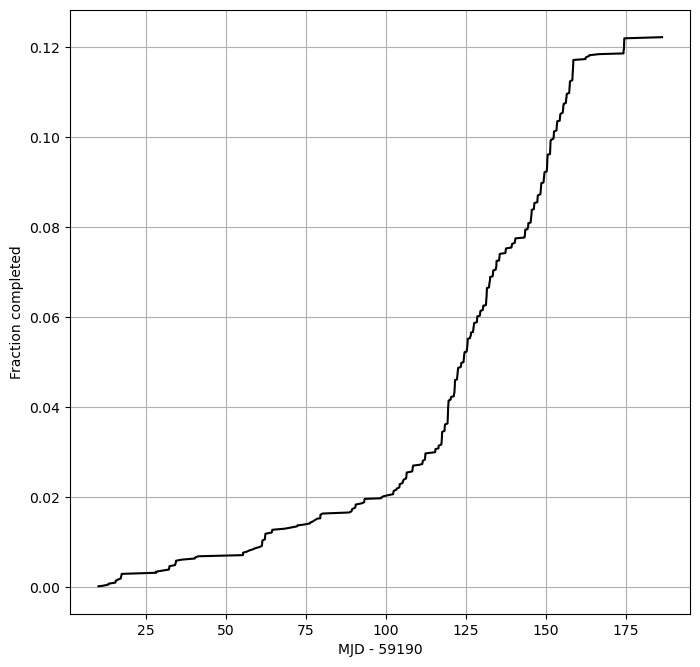

In [30]:
min_mjd = 10*(int(mjd.min())//10)
fig, axes = plt.subplots(1, 1, figsize=(8, 8), dpi=100)
p1 = axes.plot(unique_mjd[ii][i3] - min_mjd, N_completed/N_targets, 'k-')
foo = axes.set_xlabel(f'MJD - {min_mjd:d}')
foo = axes.set_ylabel('Fraction completed')
foo = axes.grid(True)
# foo = axes.legend(loc=1)

### Exercise

* Break down the progress by target class, target bit, etc.

## Using Relationships in SQLAlchemy

Here we demonstrate how table relationships can simplify certain queries. First we grab a single `db.Exposure` object.

In [31]:
exposure = db.dbSession.query(db.Exposure).filter(db.Exposure.expid == 86507).one()
exposure

Exposure(night=20210428, expid=86507, tileid=401)

How do we get the `db.Frame` objects associated with this exposure?

In [32]:
exposure.frames

[Frame(expid=86507, camera='b0'),
 Frame(expid=86507, camera='b1'),
 Frame(expid=86507, camera='b2'),
 Frame(expid=86507, camera='b3'),
 Frame(expid=86507, camera='b4'),
 Frame(expid=86507, camera='b5'),
 Frame(expid=86507, camera='b6'),
 Frame(expid=86507, camera='b7'),
 Frame(expid=86507, camera='b8'),
 Frame(expid=86507, camera='b9'),
 Frame(expid=86507, camera='r0'),
 Frame(expid=86507, camera='r1'),
 Frame(expid=86507, camera='r2'),
 Frame(expid=86507, camera='r3'),
 Frame(expid=86507, camera='r4'),
 Frame(expid=86507, camera='r5'),
 Frame(expid=86507, camera='r6'),
 Frame(expid=86507, camera='r7'),
 Frame(expid=86507, camera='r8'),
 Frame(expid=86507, camera='r9'),
 Frame(expid=86507, camera='z0'),
 Frame(expid=86507, camera='z1'),
 Frame(expid=86507, camera='z2'),
 Frame(expid=86507, camera='z3'),
 Frame(expid=86507, camera='z4'),
 Frame(expid=86507, camera='z5'),
 Frame(expid=86507, camera='z6'),
 Frame(expid=86507, camera='z7'),
 Frame(expid=86507, camera='z8'),
 Frame(expid=8

What tile is associated with this exposure?

In [33]:
exposure.tile

Tile(tileid=401)

What fiberassignments were made on this tile?

In [34]:
exposure.tile.fiberassign[:20]

[Fiberassign(tileid=401, targetid=2305843019003212516, location=1483),
 Fiberassign(tileid=401, targetid=2305843019003213608, location=1464),
 Fiberassign(tileid=401, targetid=2305843019003212073, location=521),
 Fiberassign(tileid=401, targetid=2305843019003213545, location=520),
 Fiberassign(tileid=401, targetid=2305843019003224230, location=519),
 Fiberassign(tileid=401, targetid=2305843019003217368, location=505),
 Fiberassign(tileid=401, targetid=2305843019003207059, location=1416),
 Fiberassign(tileid=401, targetid=2305843019003208522, location=1418),
 Fiberassign(tileid=401, targetid=2305843019003205573, location=1442),
 Fiberassign(tileid=401, targetid=2305843019003214342, location=1443),
 Fiberassign(tileid=401, targetid=2305843019003213965, location=1420),
 Fiberassign(tileid=401, targetid=2305843019003214124, location=1396),
 Fiberassign(tileid=401, targetid=2305843019003213725, location=1419),
 Fiberassign(tileid=401, targetid=2305843019003215192, location=1395),
 Fiberassi

What redshifts were measured on this tile?

In [35]:
exposure.tile.ztile_redshifts[:20]

[Ztile(targetid=2305843019007400014, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007397295, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007394719, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007399070, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007396417, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007394531, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007398261, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007400147, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007399056, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007397105, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=2305843019007398534, tileid=401, spgrp='cumulative', spgrpval=20210428),
 Ztile(targetid=23058

### Exercise

* Rewrite example queries above using relationships wherever possible.

## Using q3c in SQLAlchemy

[q3c](https://github.com/segasai/q3c) ([Koposov & Bartunov 2006](https://ui.adsabs.harvard.edu/abs/2006ASPC..351..735K/abstract)) is a popular library that provides spatial indexing and searching in astronomical databases. Here we'll demonstrate how to access this functionality in SQLAlchemy.  Any database function is accessible with `sqlalchemy.sql.func`.  This is a radial ("cone") search on an arbitrary point in the DESI footprint:

In [36]:
q = db.dbSession.query(db.Photometry, db.Zpix, func.q3c_dist(db.Photometry.ra, db.Photometry.dec, 180.0, 0.0).label("radial_distance")).join(db.Zpix).filter(func.q3c_radial_query(db.Photometry.ra, db.Photometry.dec, 180.0, 0.0, 1.0/60.0)).all()  # 1 arcmin
q

[(Photometry(targetid=39627787744581338), Zpix(targetid=39627787744581338, survey='sv1', program='dark'), 0.0155553060060447),
 (Photometry(targetid=39627787744581338), Zpix(targetid=39627787744581338, survey='sv3', program='dark'), 0.0155553060060447),
 (Photometry(targetid=39627787744581419), Zpix(targetid=39627787744581419, survey='sv3', program='bright'), 0.0162460808451895),
 (Photometry(targetid=2305843037487501690), Zpix(targetid=2305843037487501690, survey='sv3', program='backup'), 0.0155599700637323),
 (Photometry(targetid=39627787744581040), Zpix(targetid=39627787744581040, survey='sv3', program='bright'), 0.0166239589966163),
 (Photometry(targetid=39627787744581068), Zpix(targetid=39627787744581068, survey='sv3', program='bright'), 0.0154899710431295),
 (Photometry(targetid=39627787744581408), Zpix(targetid=39627787744581408, survey='sv3', program='bright'), 0.00272573517354215),
 (Photometry(targetid=39627787748769959), Zpix(targetid=39627787748769959, survey='sv3', program

### Exercise

* What spectra are near your favourite object?